In [12]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torchdata.datapipes as dp
import torchtext.transforms as T
import spacy
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors

In [13]:
tweets = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
texts = tweets['text']
labels = tweets['airline_sentiment']
tweets = pd.DataFrame(list(zip(texts, labels)), columns=['texts', 'labels'])
tweets

,texts,labels
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


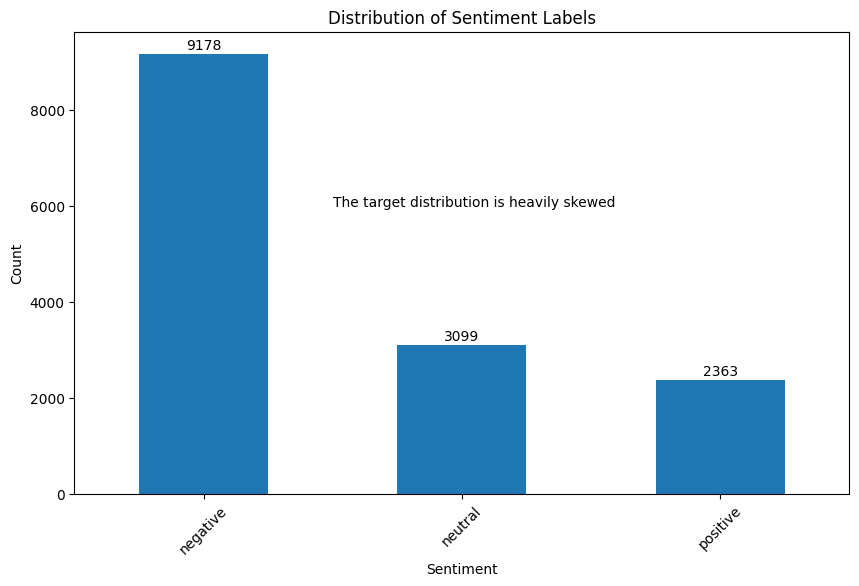

In [14]:
# Count occurrences of each label
label_counts = tweets['labels'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Annotate the plot
for i, count in enumerate(label_counts):
    plt.text(i, count + 100, str(count), ha='center')

plt.annotate('The target distribution is heavily skewed', (0.5, 6000))
plt.xticks(rotation=45)
plt.show()

In [15]:
# Load Word2Vec embeddings
w2v_model = api.load('word2vec-google-news-300')

In [19]:
# Preprocess the data and tokenize the sentences
def preprocess(df):
    
    # Remove special characters
    tweets['texts'] = tweets['texts'].apply(lambda x: x.replace('@',''))
    # Tokenize the sentence
    df['tokenized_texts'] = df['texts'].apply(lambda x: x.lower().split())

    return df

tweets = preprocess(tweets)
tweets

,texts,labels,tokenized_texts
0,VirginAmerica What dhepburn said.,neutral,"[virginamerica, what, dhepburn, said.]"
1,VirginAmerica plus you've added commercials to...,positive,"[virginamerica, plus, you've, added, commercia..."
2,VirginAmerica I didn't today... Must mean I ne...,neutral,"[virginamerica, i, didn't, today..., must, mea..."
3,VirginAmerica it's really aggressive to blast ...,negative,"[virginamerica, it's, really, aggressive, to, ..."
4,VirginAmerica and it's a really big bad thing ...,negative,"[virginamerica, and, it's, a, really, big, bad..."
...,...,...,...
14635,AmericanAir thank you we got on a different fl...,positive,"[americanair, thank, you, we, got, on, a, diff..."
14636,AmericanAir leaving over 20 minutes Late Fligh...,negative,"[americanair, leaving, over, 20, minutes, late..."
14637,AmericanAir Please bring American Airlines to ...,neutral,"[americanair, please, bring, american, airline..."
14638,"AmericanAir you have my money, you change my f...",negative,"[americanair, you, have, my, money,, you, chan..."


In [ ]:
# Load Word2Vec embeddings
w2v_model = KeyedVectors.load_word2vec_format('path_to_word2vec_file', binary=True)

In [31]:
def sentences_to_embeddings(sentences):
    embeddings = []
    max_length = max(len(sentence) for sentence in sentences)  # Find the maximum length
    for sentence in sentences:
        sentence_embeddings = []
        for word in sentence:
            if word in w2v_model.key_to_index:
                sentence_embeddings.append(w2v_model[word])
            else:
                # Handle out-of-vocabulary words (e.g., replace with zeros or a special token)
                # For example:
                # sentence_embeddings.append(np.zeros(w2v_model.vector_size))
                pass
        # Pad the sequence to the maximum length
        while len(sentence_embeddings) < max_length:
            sentence_embeddings.append(np.zeros(w2v_model.vector_size))  # Pad with zeros
        embeddings.append(sentence_embeddings)
    return torch.tensor(embeddings)

data = sentences_to_embeddings(tweets['tokenized_texts'])

In [32]:
label_encoder = LabelEncoder()
tweets['labels'] = label_encoder.fit_transform(tweets['labels'])
labels = torch.tensor(tweets['labels'], dtype=torch.long)

In [41]:
# Split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [33]:
# Define and train the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        return self.fc(out)

In [39]:
# Initialize model
model = GRUModel(input_size=w2v_model.vector_size, hidden_size=128, output_size=1, num_layers=2, num_classes=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
from tqdm import tqdm  # Import tqdm

# Train the model on the training data
num_epochs = 10
for epoch in range(num_epochs):
    # Training loop with tqdm
    running_train_loss = 0.0
    for inputs, label in tqdm(zip(train_data, train_labels), total=len(train_data), desc=f'Epoch {epoch + 1}/Training'):
        optimizer.zero_grad()
        inputs = inputs.float()  # Convert input to float32
        outputs = model(inputs.unsqueeze(0))
        loss = criterion(outputs, label.unsqueeze(0))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_data)
    train_losses.append(train_loss)

    # Validation loop with tqdm
    running_val_loss = 0.0
    for inputs, label in tqdm(zip(val_data, val_labels), total=len(val_data), desc=f'Epoch {epoch + 1}/Validation'):
        inputs = inputs.float()  # Convert input to float32
        outputs = model(inputs.unsqueeze(0))
        val_loss = criterion(outputs, label.unsqueeze(0))
        running_val_loss += val_loss.item()
    val_loss = running_val_loss / len(val_data)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

# Create DataFrame for plotting
loss_df = pd.DataFrame({'Train Loss': train_losses, 'Validation Loss': val_losses})

# Plot the training and validation losses
plt.figure(figsize=(15, 10))
plt.plot(loss_df['Train Loss'], label='Training Loss')
plt.plot(loss_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


Epoch 1/Training:  40%|███▉      | 4653/11712 [02:16<03:27, 34.07it/s]


KeyboardInterrupt: 

## Test prediction

In [ ]:
# Define the sentence
sentence = 'the flight was awful'

# Tokenize the sentence and convert it into a tensor
sentence_indices = torch.LongTensor([word_to_idx.get(word, 0) for word in sentence.split()])

# Pass the tensor through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(sentence_indices.unsqueeze(0))  # Add extra dimension for batch size

# Get the predicted label index
predicted_label_index = torch.argmax(outputs, dim=1).item()

# Map the predicted label index back to its original value
predicted_label = label_encoder.inverse_transform([predicted_label_index])

print("Predicted sentiment:", predicted_label)